- Given predicted shortages and surpluses, how should bikes be rebalanced ?

In [1]:
import pandas as pd 
import numpy as np 

In [3]:
pred = pd.read_parquet('/Users/moaizwazir/Documents/GitHub/tfl-bike-rebalancing/processed_data/rf_predictions.parquet')
pred.head() 

,station_id,time_bucket,predicted_status
0,001161,2022-09-12 10:00:00,surplus
1,001093,2022-09-12 10:00:00,balanced
2,300083,2022-09-12 10:00:00,balanced
3,001085,2022-09-12 10:30:00,balanced
4,200128,2022-09-12 10:30:00,surplus


In [4]:
#decide action rules 

def decide_action(status):
    if status == 'shortage':
        return 'send_bikes'
    elif status == 'surplus':
        return 'remove_bikes'
    else:
        return 'do_nothing'

pred['action'] = pred['predicted_status'].apply(decide_action)
pred['action'].value_counts()

action
do_nothing      11975417
send_bikes       3510592
remove_bikes     2258635
Name: count, dtype: int64

In [5]:
# where do bikes come from when a shortage is predicted ?
# for each time bucket:
# - identify stations with send_bikes
# - identify stations with remove_bikes
# - match them one to one.

rebalancing_plan = []

for t, g in pred.groupby("time_bucket"):
    shortages = g[g["action"] == "send_bikes"]
    surpluses = g[g["action"] == "remove_bikes"]

    n = min(len(shortages), len(surpluses))

    for i in range(n):
        rebalancing_plan.append({
            "time_bucket": t,
            "from_station": surpluses.iloc[i]["station_id"],
            "to_station": shortages.iloc[i]["station_id"],
            "bikes": 1
        })

plan = pd.DataFrame(rebalancing_plan)
plan.head()


,time_bucket,from_station,to_station,bikes
0,2022-09-12 10:30:00,200128,001190,1
1,2022-09-12 10:30:00,001161,001011,1
2,2022-09-12 10:30:00,003429,001065,1
3,2022-09-12 11:00:00,001067,300083,1
4,2022-09-12 11:00:00,001075,001190,1


In [6]:
pred[pred["predicted_status"] == "shortage"].shape[0] #no. of shortages predicted

3510592

In [7]:
plan.shape[0] #no. of shortages that could be acted on

1962582

In [8]:
coverage = plan.shape[0] / pred[pred["predicted_status"]=="shortage"].shape[0] #coverage rate
coverage


0.5590458817202341

- Roughly 56% of predicted shortage events could be proactively addressed. 
- However, in reality, rebalancing would also be limited by vehicle travel times and capacity, which would reduce the achievable coverage. Even so, the results suggest that many shortages can be predicted early enough to be acted on. 

In [10]:
from datetime import datetime 

#time of day analysis -> when do predicted shortages occur ?

pred["hour"] = pred["time_bucket"].dt.hour
print(pred[["time_bucket", "hour"]].head())

shortages_by_hour = (
    pred[pred["predicted_status"] == "shortage"]
    .groupby("hour")
    .size()
)

print(shortages_by_hour)


          time_bucket  hour
0 2022-09-12 10:00:00    10
1 2022-09-12 10:00:00    10
2 2022-09-12 10:00:00    10
3 2022-09-12 10:30:00    10
4 2022-09-12 10:30:00    10
hour
0      10294
1       5243
2       2842
3       1683
4       2094
5       6775
6     178248
7     370872
8     489433
9     183532
10     83218
11     69018
12     81068
13     97982
14    106253
15    122569
16    346626
17    429153
18    404718
19    207182
20    122588
21     84813
22     63650
23     40738
dtype: int64


<Axes: title={'center': 'Predicted shortages by hour of day'}, xlabel='hour'>

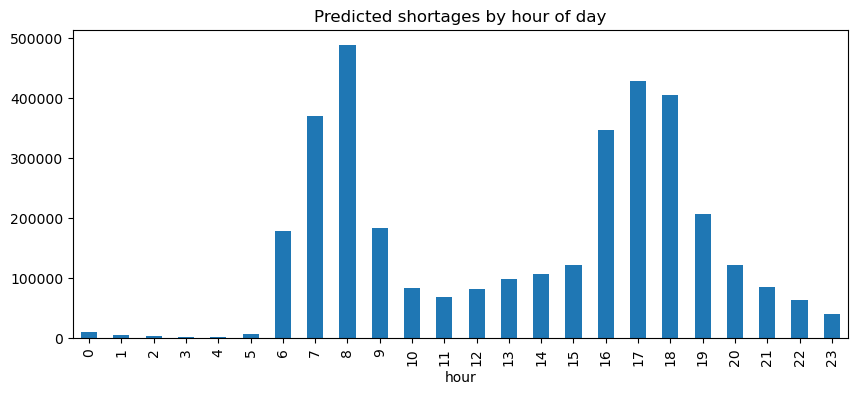

In [11]:
#plot 

shortages_by_hour.plot(
    kind="bar",
    figsize=(10,4),
    title="Predicted shortages by hour of day"
)


- As expected, predicted shortages tend to peak during morning hours (7 - 9AM) and evening hours (4 - 6PM).

<Axes: title={'center': 'Predicted surpluses by hour of day'}, xlabel='hour'>

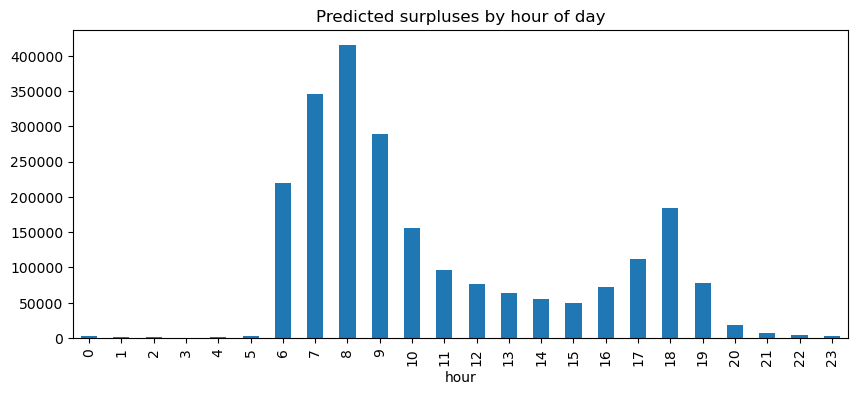

In [12]:
#when are surplus stations available -> should expect there to be an alignment in times.
surplus_by_hour = (
    pred[pred["predicted_status"] == "surplus"]
    .groupby("hour")
    .size()
)

surplus_by_hour.plot(
    kind="bar",
    figsize=(10,4),
    title="Predicted surpluses by hour of day"
)


In [13]:
#no. of shortages / hr
shortages_hour = (
    pred[pred["predicted_status"] == "shortage"]
    .groupby("hour")
    .size()
)

#no. of matched actions / hr
actions_hour = (
    plan.groupby("time_bucket")
        .first()
        .reset_index()
        .assign(hour=lambda x: x["time_bucket"].dt.hour)
        .groupby("hour")
        .size()
)

coverage_hour = (
    actions_hour / shortages_hour
).fillna(0)

coverage_hour




hour
0     0.105887
1     0.133893
2     0.154469
3     0.170529
4     0.203438
5     0.139041
6     0.008387
7     0.004586
8     0.003845
9     0.010630
10    0.023673
11    0.028543
12    0.024325
13    0.020126
14    0.018559
15    0.016081
16    0.005686
17    0.004590
18    0.004865
19    0.008765
20    0.012073
21    0.015976
22    0.018837
23    0.023541
dtype: float64

<Axes: title={'center': 'Shortage coverage rate by hour of day'}, xlabel='hour'>

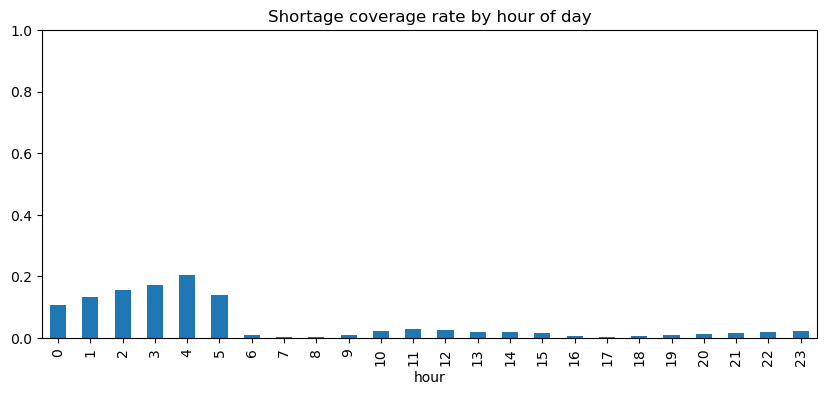

In [14]:
coverage_hour.plot(
    kind="bar",
    figsize=(10,4),
    ylim=(0,1),
    title="Shortage coverage rate by hour of day"
)


- Here shortage coverage peaks during off-peak times (from 12 - 5AM). 
- This is because during these hours demand for bikes is low, bikes redistributed naturally, more stations in surplus and vehicles can move freely.
- Therefore rebalancing is most effective during off-peak hours, not as a real time response during peak demand. 